In [234]:
import numpy as np
from numpy import exp, sqrt, pi
import random
import collections
import itertools
import matplotlib.pyplot as plt
from collections import Counter

In [235]:
def compute_amplitudes(bit_dict, indices):
    # Initialize a dictionary to store the sum of amplitudes for each combination
    amplitude_sums = collections.defaultdict(complex)

    # Iterate through each key-value pair in the dictionary
    for bit_string, amplitude in bit_dict.items():
        # Extract the relevant bits using the indices array
        relevant_bits = ''.join(bit_string[i] for i in indices)

        # Add the amplitude to the correct combination
        amplitude_sums[relevant_bits] += amplitude

    return amplitude_sums


def select_state(bit_dict):
    # Calculate probabilities based on the square of the magnitude of the amplitudes
    probabilities = [np.abs(amplitude)**2 for amplitude in bit_dict.values()]
    
    # Normalize the probabilities to sum to 1
    total = np.sum(probabilities)
    normalized_probabilities = [p / total for p in probabilities]

    # Randomly select a string based on these probabilities
    selected_string = np.random.choice(list(bit_dict.keys()), p=normalized_probabilities)
    
    return selected_string

def state_collapse(bit_dict, indices, measurement):
    new_state = collections.defaultdict(complex)

    for bit_string, amplitude in bit_dict.items():
        if ''.join(bit_string[i] for i in indices) == measurement:
            total_indices = range(len(bit_string))
            remaining_bits_indices = [i for i in total_indices if i not in indices]
            new_bit_string = ''.join(bit_string[i] for i in remaining_bits_indices)
            new_state[new_bit_string] += amplitude
    
    # Calculate probabilities based on the square of the magnitude of the amplitudes
    probabilities = [np.abs(amplitude)**2 for amplitude in new_state.values()]
    
    # Normalize the probabilities to sum to 1
    total = sqrt(sum(probabilities))

    return {key: value / total for key, value in new_state.items()}



def flip_at_index(binary_string, index):
    """
    Flip the character at the specified index in a binary string.
    
    :param binary_string: A string consisting of '0's and '1's.
    :param index: The index of the character to flip.
    :return: The modified string with the character at the given index flipped.
    """
    if index < 0 or index >= len(binary_string):
        raise IndexError("Index out of range")

    # Convert the string to a list
    char_list = list(binary_string)

    # Flip the character at the specified index
    char_list[index] = '0' if char_list[index] == '1' else '1'

    # Convert the list back to a string and return
    return ''.join(char_list)

def replace_at_index(binary_string, index):
    """
    Replace the character at the specified index in a binary string with '0' and '1'.

    :param binary_string: A string consisting of '0's and '1's.
    :param index: The index of the character to replace.
    :return: Two strings, one with the character at the index replaced by '0' and the other by '1'.
    """
    if index < 0 or index >= len(binary_string):
        raise IndexError("Index out of range")

    # Convert the string to a list
    char_list = list(binary_string)

    # Create two copies of the list
    list_with_0 = char_list.copy()
    list_with_1 = char_list.copy()

    # Replace the character at the specified index
    list_with_0[index] = '0'
    list_with_1[index] = '1'

    # Convert the lists back to strings
    return ''.join(list_with_0), ''.join(list_with_1)

def round_complex(z):
    """
    Round the real and imaginary parts of a complex number to five significant figures.

    :param z: Complex number to be rounded.
    :return: Complex number with real and imaginary parts rounded to five significant figures.
    """
    return complex(round(z.real, 5), round(z.imag, 5))

def plot_measurement(bitstrings, density = False):
    """
    Plots a histogram of bitstrings.
    
    Parameters:
    - bitstrings: List of bitstring values (e.g., ['0101', '1100']).
    """
    # Count the frequency of each bitstring
    bitstring_counts = Counter(bitstrings)

    # Extracting the bitstrings and their counts
    labels, counts = zip(*bitstring_counts.items())

    # convert counts to density under condition
    if density == True:
        total_count = sum(bitstring_counts.values())
        counts = [count / total_count for count in counts]

    # Positions of the bars on the x-axis
    x_pos = range(len(labels))

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size for better readability
    plt.bar(x_pos, counts, align='center', alpha=0.7, color='blue')

    # Replacing the x-axis positions with bitstring labels
    plt.xticks(x_pos, labels, rotation=45)  # Rotation for better label readability

    # Adding titles and labels
    plt.title('Frequency of Bitstrings')
    plt.xlabel('Bitstring')
    plt.ylabel('Frequency')

    # Display the plot
    plt.tight_layout()  # Adjusts subplot params for the subplot(s) to fit in the figure area
    plt.show()


# QuantumSimulator class that create a quantum circuit and simulate the effect of the quantum gates
# state vector is stored in dict, where the key correspond to the state, and the values correspond to probability amplittude
class QuantumSimulator:
    def __init__(self, n_qubits, n_cqbits):
        """
        Initialize the attributes to describe a QuantumSimulator with number of qubits.
        """
        initial_state = '0' * n_qubits
        state_vector = {initial_state : 1}
        self.state = state_vector
        self.cRegisters = ['None'] * n_cqbits
        self.functional_qubits = n_qubits
    
    # apply x gate on the target 
    def x(self, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            new_key = flip_at_index(new_key, target)
            new_state[new_key] = new_value
        self.state = new_state

    # apply h gate on the target
    def h(self, target):
        new_state = {}
        for key, value in self.state.items():
            factor = 1
            if key[target] == '1':
                factor = -1
            new_key1, new_key2 = replace_at_index(key, target)
            new_state[new_key1] = round_complex(1/sqrt(2)*value + new_state.get(new_key1, complex(0)))
            new_state[new_key2] = round_complex(factor*1/sqrt(2)*value + new_state.get(new_key2, complex(0)))
        self.state = new_state
    
    # apply t gate on the target
    def t(self, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if new_key[target] == '1':
                new_value = round_complex(np.exp(1j*pi/4)*new_value)
            new_state[new_key] = new_value
        self.state = new_state      
    
    # apply tdg gate on the target
    def t_dag(self, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if new_key[target] == '1':
                new_value = round_complex(np.exp(-1j*pi/4)*new_value)
            new_state[new_key] = new_value
        self.state = new_state  

    # apply cx gate based on the control on the target
    def cx(self, control, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if new_key[control] == '1':
                new_key = flip_at_index(new_key, target)
            new_state[new_key] = new_value
        self.state = new_state
    
    def measure(self, q_index, c_index, shots = None):
        result = []
        while shots > 0:
            measured_dict = compute_amplitudes(self.state, q_index)
            measured_state = select_state(measured_dict)
            shots = shots - 1
            result.append(measured_state)

        measured_dict = compute_amplitudes(self.state, q_index)
        measured_state = select_state(measured_dict)
        self.state = state_collapse(self.state, q_index, measured_state)
        self.cRegisters = [measured_state[c_index.index(i)] if i in c_index else b_elem for i, b_elem in enumerate(self.cRegisters)]
        return result

    ############################################
    ### display and organization functions below
    ############################################

    # clean up the state with 0 probability
    def clean(self):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if np.abs(value) != 0:
                new_state[new_key] = new_value
            new_state = {k: v for k, v in sorted(new_state.items())}
        self.state = new_state

    # check normalization of current statevector
    def normailization_check(self):
        return sum([np.abs(value)**2 for value in self.state.values()])
    
    # clean the state and return state_vector output
    def state_out(self):
        if len(self.state) == 1 and next(iter(self.state.keys())) == '':
            return 'Circuit collapse entirely'
        self.clean()
        return self.state
    
    # print out classical register
    def cOut(self):
        cResult = [i for i in self.cRegisters if i != 'None']
        return cResult
    

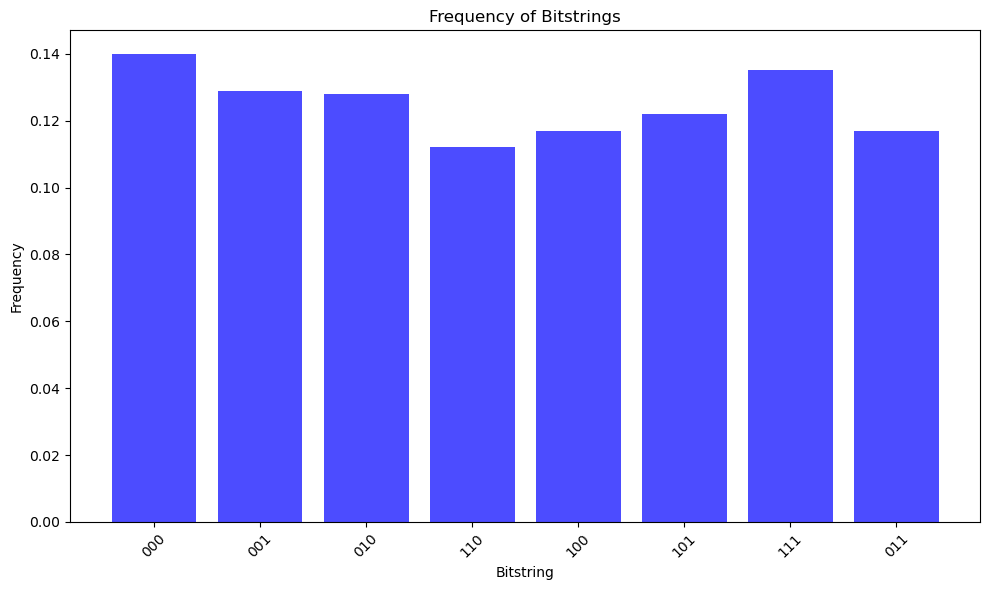

Circuit collapse entirely


In [236]:
qc = QuantumSimulator(3,2)
qc.h(0)
qc.h(1)
qc.h(2)
result = qc.measure([0,1,2], [0,1,2], 1000)
plot_measurement(result, density=True)
print(qc.state_out())